In [1]:
# default_exp inferno

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# INFERNO loss

> API details.

In [3]:
#hide
from nbdev.showdoc import *

In [4]:
from pytorch_inferno.model_wrapper import ModelWrapper
from pytorch_inferno.callback import *
from pytorch_inferno.data import get_paper_data
from pytorch_inferno.plotting import *
from pytorch_inferno.inference import *
from pytorch_inferno.utils import *
from pytorch_inferno.inferno import *

from fastcore.all import partialler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from typing import *
from collections import OrderedDict
from fastcore.all import store_attr
from abc import abstractmethod

import torch.nn.functional as F
from torch import optim, autograd, nn
import torch
from torch.distributions import Normal

In [5]:
bs = 2000
data, test = get_paper_data(200000, bs=bs, n_test=1000000)

In [6]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)
model = ModelWrapper(net)

In [7]:
%%time
model.fit(200, data=data, opt=partialler(optim.SGD,lr=1e-6), loss=None,
          cbs=[PaperInferno(float_r=0, float_l=1, aug_alpha=False),LossTracker(),SaveBest('weights/best_ie1l.h5'),EarlyStopping(10)])

1: Train=572.6675430297852 Valid=507.7537939453125
2: Train=470.9841940307617 Valid=443.6787756347656
3: Train=431.109963684082 Valid=422.8103680419922
4: Train=413.38263427734375 Valid=408.2310424804688
5: Train=397.88667358398436 Valid=397.9519970703125
6: Train=390.4134411621094 Valid=385.58074279785154
7: Train=381.3511944580078 Valid=380.6622027587891
8: Train=374.85123748779296 Valid=374.4577703857422
9: Train=368.1172686767578 Valid=368.31006408691405
10: Train=363.7329815673828 Valid=363.0515441894531
11: Train=357.5704901123047 Valid=357.18303649902344
12: Train=352.44421630859375 Valid=352.3871356201172
13: Train=347.4150628662109 Valid=347.04466125488284
14: Train=343.76560577392576 Valid=344.04308532714845
15: Train=338.07279235839843 Valid=339.66216796875
16: Train=333.88378845214845 Valid=336.18251220703127
17: Train=329.68985961914063 Valid=332.0139270019531
18: Train=327.1162814331055 Valid=326.78763977050784
19: Train=321.0374139404297 Valid=321.68993225097654
20: Trai

156: Train=262.24775390625 Valid=267.25541534423826
157: Train=262.11844146728515 Valid=267.1613293457031
158: Train=262.2566860961914 Valid=266.8608636474609
159: Train=262.0868960571289 Valid=266.91019622802736
160: Train=261.91682754516603 Valid=266.7169223022461
161: Train=261.7507862854004 Valid=266.57198150634764
162: Train=261.64692001342775 Valid=266.4131283569336
163: Train=261.4634577941895 Valid=266.33089263916014
164: Train=261.336492767334 Valid=266.2430972290039
165: Train=261.2420381164551 Valid=266.1918719482422
166: Train=261.2200843811035 Valid=265.97897186279295
167: Train=260.8978504943848 Valid=265.74465515136717
168: Train=260.6864688110352 Valid=265.828420715332
169: Train=260.73249435424805 Valid=265.6869613647461
170: Train=260.84935577392577 Valid=265.5839376831055
171: Train=260.50635681152346 Valid=265.37721466064454
172: Train=260.4032307434082 Valid=265.3600912475586
173: Train=260.2848701477051 Valid=265.2014587402344
174: Train=260.24739654541014 Valid=2

In [43]:
model.save('weights/Inferno_Test_exact_bm1l.h5')

In [7]:
model.load('weights/Inferno_Test_exact_bm1l.h5')

# Results

## BM 0

In [8]:
preds = model._predict_dl(test, pred_cb=InfernoPred())

In [9]:
df = pd.DataFrame({'pred':preds})
df['gen_target'] = test.dataset.y
df.head()

,pred,gen_target
0,2,1.0
1,3,1.0
2,6,1.0
3,2,1.0
4,2,1.0


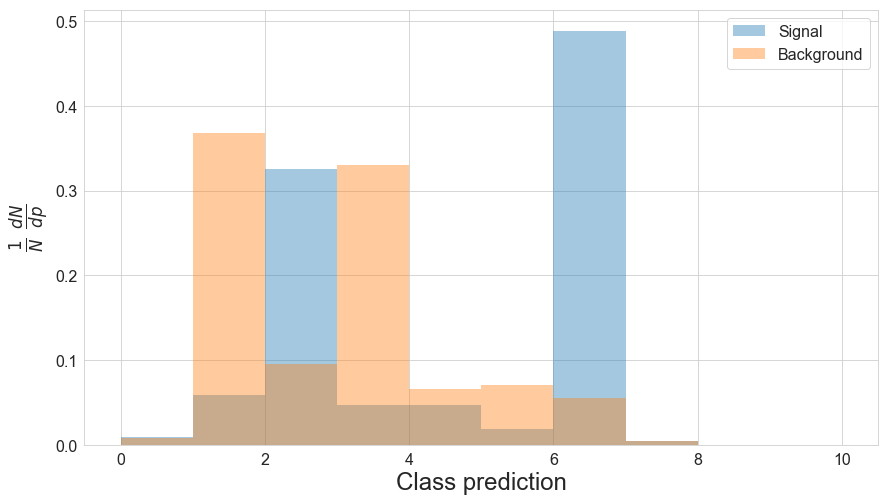

In [12]:
plot_preds(df, bin_edges=np.linspace(0,10,11))

In [10]:
bin_preds(df)

In [14]:
df.head()

,pred,gen_target,pred_bin
0,6,1.0,6
1,2,1.0,2
2,2,1.0,2
3,6,1.0,6
4,6,1.0,6


In [11]:
f_s,f_b = get_shape(df,1),get_shape(df,0)

In [16]:
f_s.sum(), f_b.sum()

(tensor(1.), tensor(1.))

In [17]:
f_s, f_b

(tensor([8.8960e-03, 5.9234e-02, 3.2600e-01, 4.6646e-02, 4.7292e-02, 1.8730e-02,
         4.8898e-01, 4.0860e-03, 2.0000e-13, 1.3600e-04]),
 tensor([8.4420e-03, 3.6782e-01, 9.5680e-02, 3.3091e-01, 6.6024e-02, 7.1166e-02,
         5.4882e-02, 4.9620e-03, 2.0000e-13, 1.1000e-04]))

In [18]:
asimov = (50*f_s)+(1000*f_b)

In [19]:
asimov, asimov.sum()

(tensor([8.8868e+00, 3.7079e+02, 1.1198e+02, 3.3324e+02, 6.8389e+01, 7.2103e+01,
         7.9331e+01, 5.1663e+00, 2.1000e-10, 1.1680e-01]), tensor(1050.))

In [20]:
n = 1050
x = np.linspace(20,80,61)
y = np.zeros_like(x)
for i,m in enumerate(x):
    pois = torch.distributions.Poisson((m*f_s)+(1000*f_b))
    y[i] = -pois.log_prob(asimov).sum()
y

array([26.30005264, 26.15856934, 26.02331924, 25.89319801, 25.76882553,
       25.64966774, 25.53600121, 25.42794991, 25.32456207, 25.22653008,
       25.13382149, 25.04603577, 24.96352768, 24.88565826, 24.81272697,
       24.7446022 , 24.68152618, 24.62297821, 24.5685463 , 24.51914597,
       24.47447586, 24.43424225, 24.39832497, 24.36699677, 24.3397274 ,
       24.31697083, 24.29829597, 24.28412437, 24.27378082, 24.26793098,
       24.2656517 , 24.26782227, 24.27371788, 24.28368378, 24.29759598,
       24.31509018, 24.33679771, 24.36209869, 24.39105606, 24.42406082,
       24.46000481, 24.50053406, 24.54384613, 24.59123611, 24.64213371,
       24.69634247, 24.75407219, 24.81535339, 24.87977219, 24.94766998,
       25.01890564, 25.09340096, 25.17131042, 25.2523613 , 25.3366909 ,
       25.42411232, 25.51444626, 25.60858917, 25.70526314, 25.80532074,
       25.90822792])

In [21]:
y_tf2 = np.array([31.626238,31.466385,31.313095,31.166267,31.025808,30.891619,30.76361
,30.641693,30.525778,30.415783,30.31162,30.213215,30.120483,30.033348
,29.951736,29.875574,29.804789,29.739307,29.679066,29.623993,29.574026
,29.5291,29.489151,29.454117,29.423939,29.398558,29.377914,29.361954
,29.35062,29.343859,29.341618,29.343842,29.350483,29.36149,29.376812
,29.396404,29.420216,29.448202,29.480318,29.516518,29.556757,29.600994
,29.649185,29.70129,29.757267,29.817076,29.88068,29.948036,30.019108
,30.093859,30.17225,30.25425,30.339819,30.42892,30.521524,30.617598
,30.7171,30.820007,30.926281,31.035892,31.148808], dtype='float32')

In [22]:
y_tf2-y_tf2.min()

array([2.2846203e+00, 2.1247673e+00, 1.9714775e+00, 1.8246498e+00,
       1.6841908e+00, 1.5500011e+00, 1.4219933e+00, 1.3000755e+00,
       1.1841602e+00, 1.0741653e+00, 9.7000313e-01, 8.7159729e-01,
       7.7886581e-01, 6.9173050e-01, 6.1011887e-01, 5.3395653e-01,
       4.6317101e-01, 3.9768982e-01, 3.3744812e-01, 2.8237534e-01,
       2.3240852e-01, 1.8748283e-01, 1.4753342e-01, 1.1249924e-01,
       8.2321167e-02, 5.6940079e-02, 3.6296844e-02, 2.0336151e-02,
       9.0026855e-03, 2.2411346e-03, 0.0000000e+00, 2.2239685e-03,
       8.8653564e-03, 1.9872665e-02, 3.5194397e-02, 5.4786682e-02,
       7.8598022e-02, 1.0658455e-01, 1.3870049e-01, 1.7490005e-01,
       2.1513939e-01, 2.5937653e-01, 3.0756760e-01, 3.5967255e-01,
       4.1564941e-01, 4.7545815e-01, 5.3906250e-01, 6.0641861e-01,
       6.7749023e-01, 7.5224113e-01, 8.3063316e-01, 9.1263199e-01,
       9.9820137e-01, 1.0873032e+00, 1.1799068e+00, 1.2759800e+00,
       1.3754826e+00, 1.4783897e+00, 1.5846634e+00, 1.6942749e

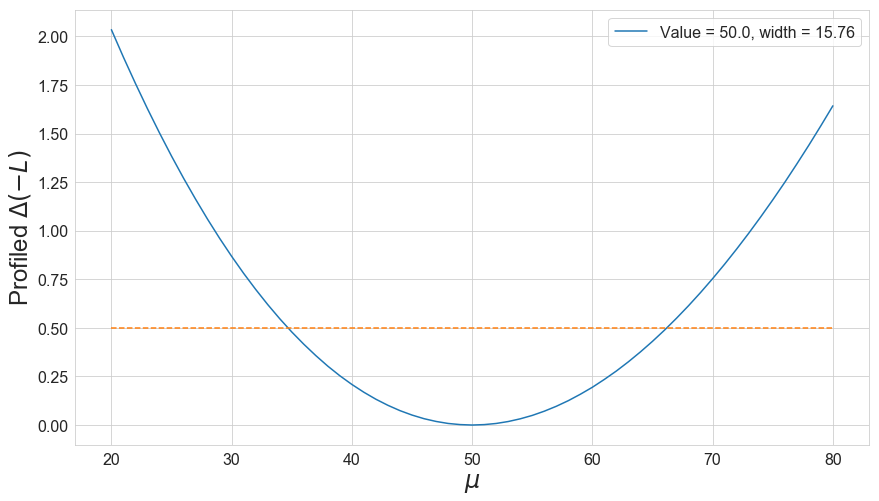

In [23]:
plot_likelihood(y-y.min())

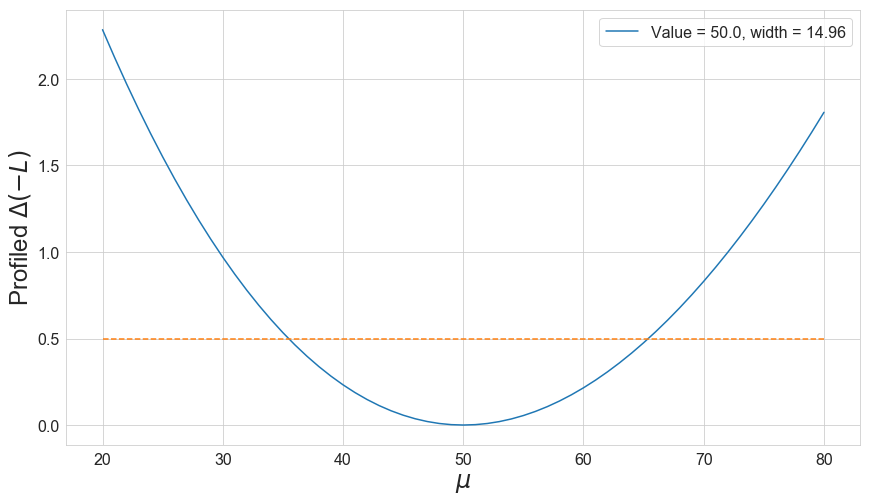

In [24]:
plot_likelihood(y_tf2-y_tf2.min())

# Nuisances - via interpolation

In [12]:
bkg = test.dataset.x[test.dataset.y.squeeze() == 0]
assert len(bkg) == 500000

In [13]:
b_shapes = get_paper_syst_shapes(bkg, df, model=model, pred_cb=InfernoPred())

Running: r=-0.2


Running: r=0


Running: r=0.2


Running: l=2.5


Running: l=3


Running: l=3.5


In [27]:
df

,pred,gen_target,pred_bin,pred_-0.2_3,pred_-0.2_3_bin,pred_0_3,pred_0_3_bin,pred_0.2_3,pred_0.2_3_bin,pred_0_2.5,pred_0_2.5_bin,pred_0_3.5,pred_0_3.5_bin
0,6,1.0,6,6,6,6,6,6,6,6,6,6,6
1,2,1.0,2,2,2,2,2,2,2,2,2,2,2
2,2,1.0,2,2,2,2,2,2,2,2,2,2,2
3,6,1.0,6,6,6,6,6,6,6,6,6,6,6
4,6,1.0,6,6,6,6,6,6,6,6,6,6,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,2,0.0,2,2,2,2,2,6,6,2,2,2,2
999996,1,0.0,1,1,1,1,1,1,1,1,1,1,1
999997,3,0.0,3,3,3,3,3,3,3,3,3,3,3
999998,6,0.0,6,6,6,6,6,6,6,6,6,6,6


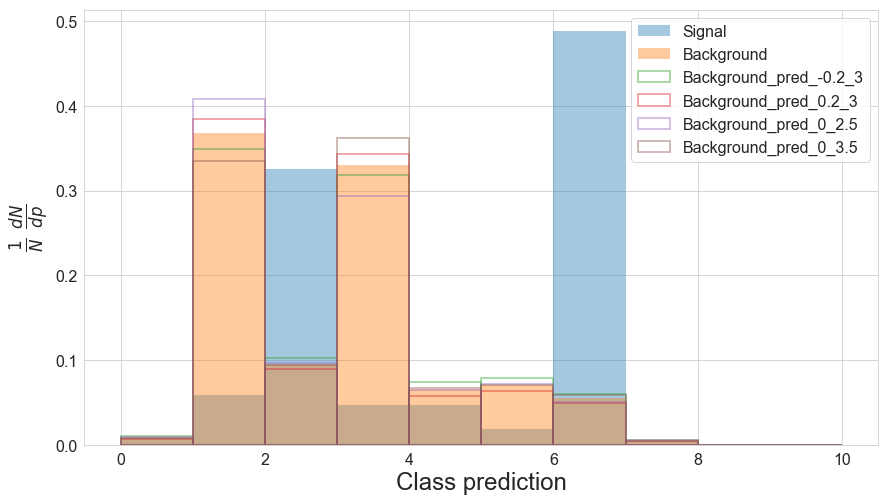

In [28]:
plot_preds(df, pred_names=['pred', 'pred_-0.2_3', 'pred_0.2_3', 'pred_0_2.5', 'pred_0_3.5'], bin_edges=np.linspace(0,10,11))

tensor([1.1056e-02, 3.8966e-01, 1.0309e-01, 2.8122e-01, 7.3088e-02, 7.9246e-02,
        5.6170e-02, 6.3360e-03, 2.0000e-13, 1.3800e-04])
tensor([1.0348e-02, 3.4981e-01, 1.0217e-01, 3.1840e-01, 7.4488e-02, 7.8688e-02,
        5.9966e-02, 5.9780e-03, 2.0000e-13, 1.4800e-04])
tensor([9.7160e-03, 3.1663e-01, 1.0075e-01, 3.4956e-01, 7.5362e-02, 7.8118e-02,
        6.4072e-02, 5.6460e-03, 2.0000e-13, 1.4200e-04])
tensor([9.1500e-03, 4.0767e-01, 9.6594e-02, 2.9373e-01, 6.4624e-02, 7.1724e-02,
        5.1086e-02, 5.3200e-03, 2.0000e-13, 1.0000e-04])
tensor([8.4420e-03, 3.6782e-01, 9.5680e-02, 3.3091e-01, 6.6024e-02, 7.1166e-02,
        5.4882e-02, 4.9620e-03, 2.0000e-13, 1.1000e-04])
tensor([7.8100e-03, 3.3465e-01, 9.4256e-02, 3.6207e-01, 6.6898e-02, 7.0596e-02,
        5.8988e-02, 4.6300e-03, 2.0000e-13, 1.0400e-04])
tensor([7.5740e-03, 4.2507e-01, 9.0056e-02, 3.0579e-01, 5.6630e-02, 6.4510e-02,
        4.5922e-02, 4.3760e-03, 2.0000e-13, 7.4000e-05])
tensor([6.8660e-03, 3.8522e-01, 8.9142e-0

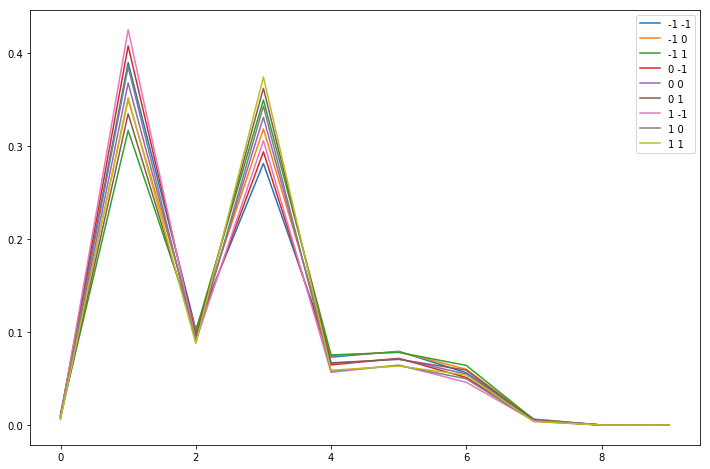

In [29]:
fig = plt.figure(figsize=(12,8))
for r in [-1,0,1]:
    for l in [-1,0,1]:
        alpha = Tensor((r,l))[None,:]
        s = interp_shape(alpha, **b_shapes).squeeze()
        print(s)
        plt.plot(s, label=f'{r} {l}')
plt.legend()

# Newton

In [14]:
profiler = partialler(calc_profile, n=1050, mu_scan=torch.linspace(20,80,61), true_mu=50)

## BM 1
r free, l fixed

In [31]:
bm1_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                            ('f_b_up',  b_shapes['f_b_up'][0][None,:]),
                            ('f_b_dw',  b_shapes['f_b_dw'][0][None,:])])

In [32]:
bm1_b_shapes['f_b_up'].shape

torch.Size([1, 10])

In [33]:
nll = profiler(f_s=f_s, n_steps=100, **bm1_b_shapes)

In [34]:
nll = to_np(nll)

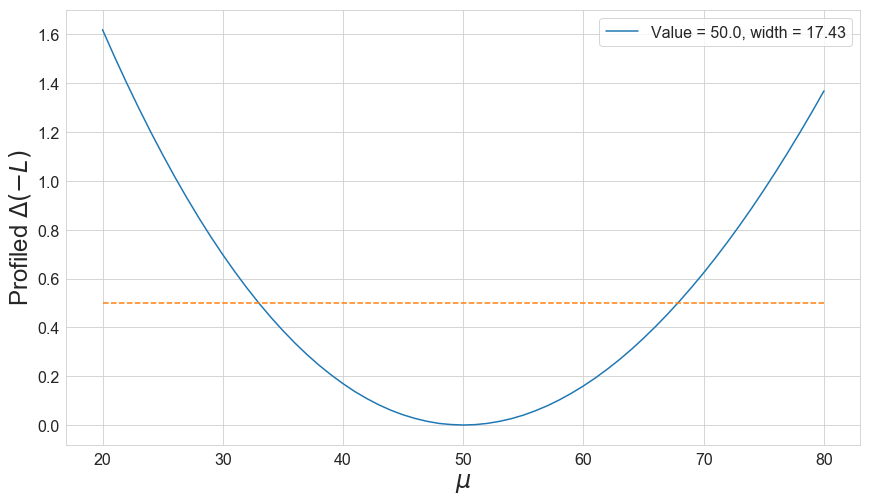

In [35]:
plot_likelihood(nll-nll.min())

## BM 1l
r fixed, l free

In [36]:
bm1l_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                             ('f_b_up',  b_shapes['f_b_up'][1][None,:]),
                             ('f_b_dw',  b_shapes['f_b_dw'][1][None,:])])

In [37]:
nll = profiler(f_s=f_s, n_steps=100, **bm1l_b_shapes)

In [38]:
nll = to_np(nll)

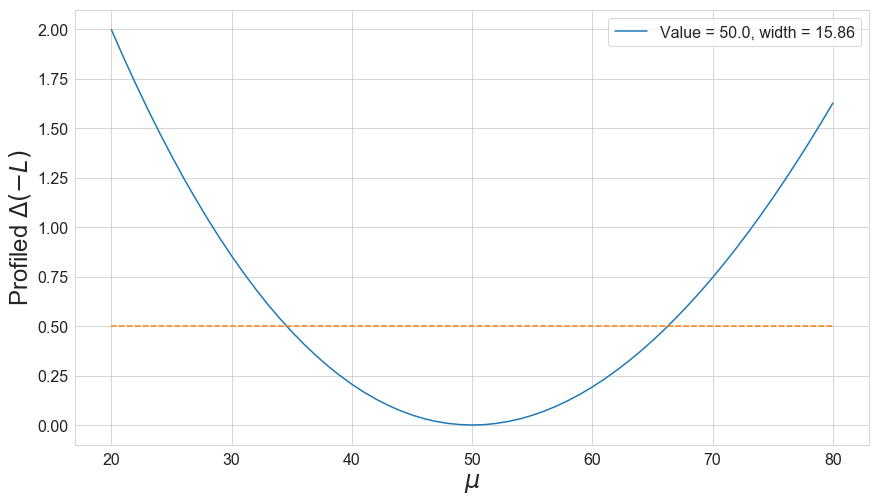

In [39]:
plot_likelihood(nll-nll.min())

## BM 2

In [40]:
nll = profiler(f_s=f_s, n_steps=100, **b_shapes)

In [41]:
nll = to_np(nll)

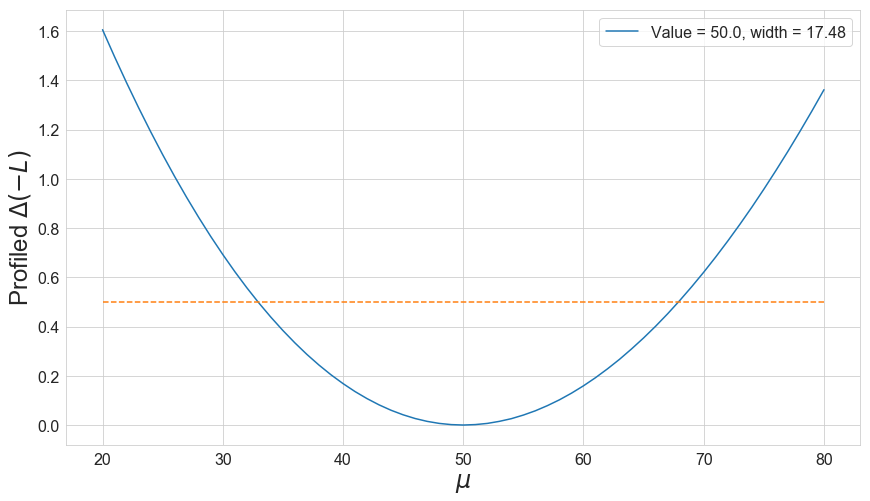

In [42]:
plot_likelihood(nll-nll.min())

## BM 3

In [15]:
alpha_aux = [Normal(0,2), Normal(0,2)]

In [16]:
nll = profiler(f_s=f_s, n_steps=100, alpha_aux=alpha_aux, **b_shapes)

In [17]:
nll = to_np(nll)

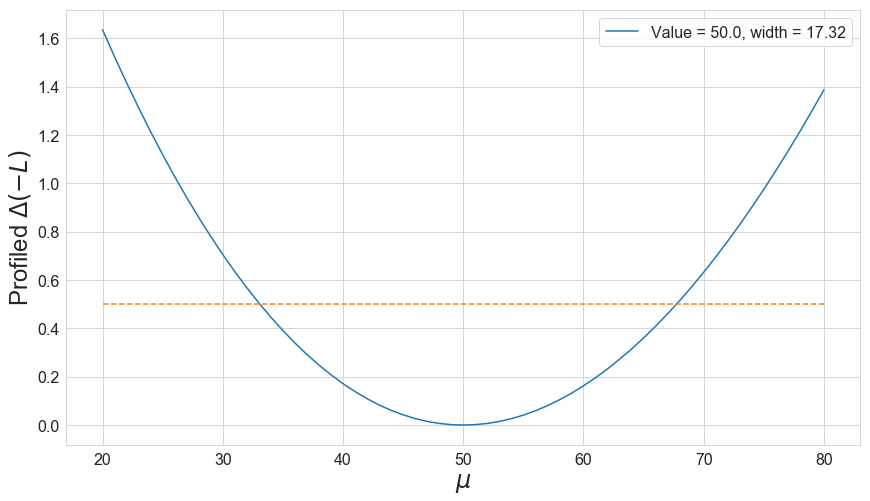

In [18]:
plot_likelihood(nll-nll.min())

## BM 4

In [19]:
alpha_aux = [Normal(0,2), Normal(0,2)]

In [20]:
nll = profiler(f_s=f_s, n_steps=100, alpha_aux=alpha_aux, float_b=True, b_aux=Normal(1000,100), **b_shapes)

Linear regime: Mu 20.0, alpha tensor([-0.4106,  0.0562, 25.6060])
Linear regime: Mu 21.0, alpha tensor([-0.3961,  0.0541, 24.6823])
Linear regime: Mu 22.0, alpha tensor([-0.3817,  0.0519, 23.7639])
Linear regime: Mu 23.0, alpha tensor([-0.3673,  0.0498, 22.8507])
Linear regime: Mu 24.0, alpha tensor([-0.3530,  0.0477, 21.9427])
Linear regime: Mu 25.0, alpha tensor([-0.3388,  0.0456, 21.0398])
Linear regime: Mu 26.0, alpha tensor([-0.3246,  0.0436, 20.1420])
Linear regime: Mu 27.0, alpha tensor([-0.3104,  0.0415, 19.2492])
Linear regime: Mu 28.0, alpha tensor([-0.2964,  0.0395, 18.3614])
Linear regime: Mu 29.0, alpha tensor([-0.2823,  0.0375, 17.4785])
Linear regime: Mu 30.0, alpha tensor([-0.2684,  0.0355, 16.6006])
Linear regime: Mu 31.0, alpha tensor([-0.2545,  0.0336, 15.7275])
Linear regime: Mu 32.0, alpha tensor([-0.2406,  0.0316, 14.8591])
Linear regime: Mu 33.0, alpha tensor([-0.2268,  0.0297, 13.9956])
Linear regime: Mu 34.0, alpha tensor([-0.2130,  0.0278, 13.1367])
Linear reg

In [21]:
nll = to_np(nll)

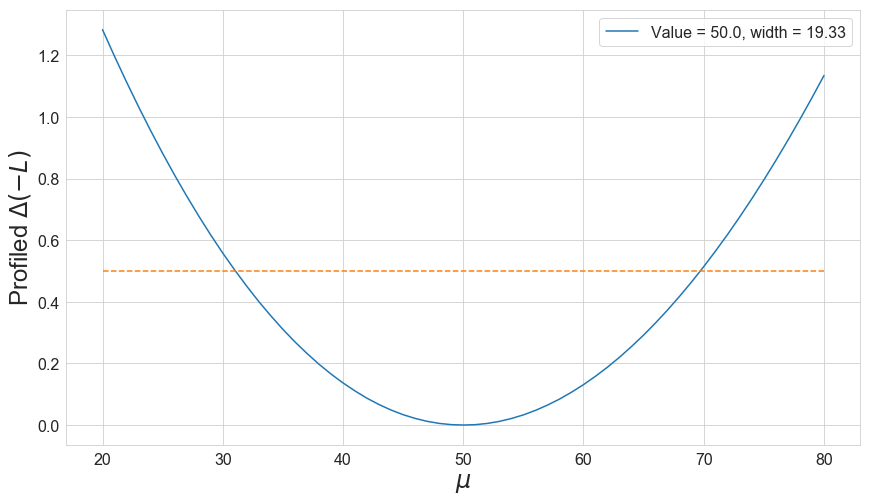

In [22]:
plot_likelihood(nll-nll.min())